In [0]:
!pip install pandas_ml
import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
nltk.download('stopwords')
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
from keras.layers import Dense, Input
from keras.layers.merge import concatenate
%matplotlib inline
import tensorflow as tf
tf.test.gpu_device_name()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


'/device:GPU:0'

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
link = 'https://drive.google.com/open?id=1pngW6PI59tM-CvEgeo3-zzttsnwkrZ7j'
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('train.csv')  
train = pd.read_csv('train.csv')

link = 'https://drive.google.com/open?id=11161ODTBOgOax6ZHHhsOgiAue1IyRUI2'
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('test.csv')  
testset = pd.read_csv('test.csv')

link = 'https://drive.google.com/open?id=18BnJN1VZ6ikEuvIvvt86odYrq2ToyKWr'
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('train_mobile.csv')  



In [0]:
beauty_train = train.iloc[:286583]
fashion_train = train.iloc[286584:506285]
mobile_train = train.iloc[506285:]


beauty_test = testset.iloc[:76545]
fashion_test = testset.iloc[76545:131985]
mobile_test = testset.iloc[131985:]

#beauty_train.head()
#beauty_train.tail()
#fashion_train.head()
#fashion_train.tail()
#mobile_train.head()
#mobile_train.tail()



In [0]:
####Model building

import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils


from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
%matplotlib inline


In [0]:
#Data cleaning
train['title'] = train.title.str.replace('lip', '')

#Double check if cleaned
train['Contains'] = train.title.str.contains('lip')
train[train['Contains'] == True]


,itemid,title,Category,image_path,Contains


In [0]:

training = beauty_train
percentage_split = 1
max_words = 1000
batch_size = 10000
epochs = 20

train = training.sample(frac=1).reset_index(drop=True) #Shuffles the rows in the Train.CSV because the rows are arranged neatly in the order of big categories (Beu, Fas, mob)
train_size = int(len(train) * percentage_split) 
train_title = train['title'][:train_size] #Takes 70% of the training data to train
train_Category = train['Category'][:train_size] #Takes 70% of the training data to train

eval_title = train['title'][train_size:] #Takes remaining 30% of the training data to test
eval_Category = train['Category'][train_size:] #Takes remaining 30% of the training data to test

train_title = train['title']
train_Category = train['Category']

tokenize = text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(train_title) # only fit on train

x_train = tokenize.texts_to_matrix(train_title)
x_eval = tokenize.texts_to_matrix(eval_title)

encoder = LabelEncoder()
encoder.fit(train_Category)
y_train = train_Category
y_eval = eval_Category
# y_train = encoder.transform(train_Category)
# y_eval = encoder.transform(eval_Category)


num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_eval = utils.to_categorical(y_eval, num_classes)


print('Found %d unique words.' % len(tokenize.word_index))

Found 29419 unique words.


In [0]:
# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 512)               512512    
_________________________________________________________________
activation_17 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 512)               262656    
_________________________________________________________________
activation_18 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 512)               262656    
__________

Train on 257924 samples, validate on 28659 samples
Epoch 1/20
257924/257924 [==============================] - 4s 15us/step - loss: 1.8574 - acc: 0.4418 - val_loss: 1.2814 - val_acc: 0.6345
Epoch 2/20
257924/257924 [==============================] - 3s 13us/step - loss: 1.1528 - acc: 0.6737 - val_loss: 0.9947 - val_acc: 0.7094
Epoch 3/20
257924/257924 [==============================] - 3s 12us/step - loss: 0.9623 - acc: 0.7190 - val_loss: 0.8779 - val_acc: 0.7365
Epoch 4/20
257924/257924 [==============================] - 3s 12us/step - loss: 0.8727 - acc: 0.7386 - val_loss: 0.8328 - val_acc: 0.7494
Epoch 5/20
257924/257924 [==============================] - 3s 12us/step - loss: 0.8281 - acc: 0.7491 - val_loss: 0.8039 - val_acc: 0.7559
Epoch 6/20
257924/257924 [==============================] - 3s 12us/step - loss: 0.7950 - acc: 0.7572 - val_loss: 0.7860 - val_acc: 0.7589
Epoch 7/20
257924/257924 [==============================] - 3s 12us/step - loss: 0.7706 - acc: 0.7631 - val_loss: 0

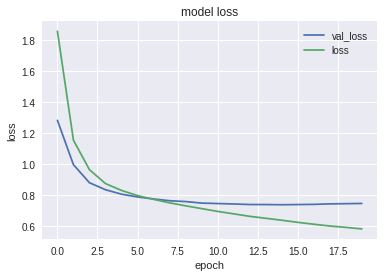

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
              
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

def display_training_graph(history):
    # summarize history for loss
    plt.plot(history.history['val_loss'])
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['val_loss', 'loss'], loc='upper right')
    plt.draw()


display_training_graph(history)


**SAVE MODEL** 

In [0]:
model_json = model.to_json()
with open("beauty_model.json", "w") as json_file:
  json_file.write(model_json)
model.save_weights("beauty_model.h5")
print("Saved model to disk")

from google.colab import files
files.download('beauty_model.h5')
files.download('beauty_model.json')

Saved model to disk


**EVALUATION SCORE** 

In [0]:
### computing training accuracy using inhouse testset

evaluation_score = model.evaluate(x_eval, y_eval,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', evaluation_score[1])

**confusion matrix**

In [0]:
#predicting evaluation set
predict_train = x_train


train_predict = model.predict(predict_train, batch_size=batch_size, verbose=1)
train_predict = pd.DataFrame(data=train_predict)
train_predict = train_predict.idxmax(axis=1)
train_predict

In [0]:
returns a evaluation(20% unseen training set) comparision between y_eval(answer) and y_predict(prediction)
predict_label = y_train

predict_label = pd.DataFrame(data=predict_label)
predict_label = predict_label.idxmax(axis=1)
comparison = pd.concat([train_predict, predict_label ], axis=1)
comparison


In [0]:
from sklearn.metrics import confusion_matrix
comparison.columns = ['Predict', 'Category1']
y_pred = comparison.Predict.tolist()
y_true = comparison.Category1.tolist()
y_pred = np.asarray(y_pred)
y_true = np.asarray(y_true)
cm = np.zeros((17, 17), dtype=int)
np.add.at(cm, [y_true, y_pred], 1)
cm
cmdf = pd.DataFrame(data=cm)
cmdf

# cmdf.to_csv('beauty_cm_lesslip.csv')
# from google.colab import files
# files.download('beauty_cm_lesslip.csv')


In [0]:
#WORD LENGTH
import seaborn as sns
pd.set_option('max_colwidth', 150)

merged = pd.concat([comparison, train], axis=1)
output = merged[merged['Category1'] != merged['Predict']]
output['strlen'] = output.title.str.split()
output['wordlen'] = output["strlen"].apply(lambda x: len(x))
output = output.sort_values(by=['wordlen'])
output

plt.figure(figsize=(20,6))
plot = sns.countplot(x='wordlen', data=output)
plt.title('-- %', fontsize= 20)
ax = plot.axes

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


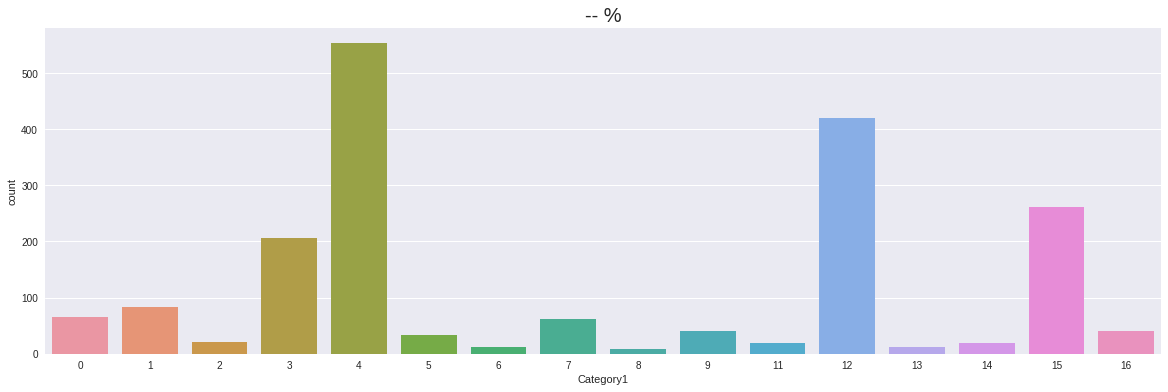

In [0]:
import seaborn as sns
pd.set_option('max_colwidth', 150)

merged = pd.concat([comparison, train], axis=1)
# output = merged[merged['Category1'] != merged['Predict']]
output = merged
output['Contains'] = output.title.str.contains('liner')
output = output[output['Contains'] == True]


plt.figure(figsize=(20,6))
plot = sns.countplot(x='Category1', data=output)
plt.title('-- %', fontsize= 20)
ax = plot.axes


In [0]:
#wrong entries
comparison['que'] = np.where(comparison.iloc[:, 0] != comparison.iloc[:, 1], 1, 0 )
comparison = comparison[comparison.que == 1]
comparison = comparison.iloc[:,[0,2]]
comparison.columns = ['1', '2']
excel = comparison['1'].value_counts()
excel


In [0]:
excel.to_csv('excel.csv') 
from google.colab import files
files.download('excel.csv')



**Predicting actual testset**

In [0]:
### Predicting using actual testset

testing = fashion_test


test_title = testing['title']
x_test = tokenize.texts_to_matrix(test_title)
test_predict = model.predict(x_test, batch_size=batch_size, verbose=1)
test_predict = pd.DataFrame(data=test_predict)
test_predict = test_predict.idxmax(axis=1)
test_predict

In [0]:
#Download prediction classes given test set
test_predict.to_csv('predict.csv') 
from google.colab import files
files.download('predict.csv')
